# SCRAPING NEWS HEADLINES and S&P500 DATA

### News Headline Scrape

In [1]:
from newsdataapi import NewsDataApiClient
import pandas as pd
import os
import time
from datetime import datetime, timedelta
from pytz import timezone

#Initialize API
api = NewsDataApiClient(apikey=os.getenv("NEWSDATA_API_KEY"))

#Defining Categories
categories = ["business", "politics"]
all_articles = []

#Path to master CSV
file_path = "news_headlines_master.csv"

#Load existing data
if os.path.exists(file_path):
    existing_df = pd.read_csv(file_path)
    existing_links = set(existing_df["link"])
else:
    existing_df = pd.DataFrame()
    existing_links = set()

#Loop through each category and scrape the latest headlines
for category in categories:
    print(f"Fetching {category} headlines...")
    try:
        response = api.news_api(
            category=category,
            language="en",
            country="us",
            max_result=100,
            scroll=True
        )
        results = response.get("results", [])
        for article in results:
            link = article.get("link")
            if link and link not in existing_links:
                all_articles.append({
                    "pubDate":     article.get("pubDate"),
                    "title":       article.get("title"),
                    "description": article.get("description"),
                    "source":      article.get("source_id"),
                    "link":        link,
                    "category":    category
                })
    except Exception as e:
        print(f"Error fetching {category}: {e}")
    time.sleep(1)

#Convert to DataFrame
new_df = pd.DataFrame(all_articles)

#Append new articles to the master file
if not new_df.empty:
    final_df = pd.concat([existing_df, new_df], ignore_index=True)
    final_df.to_csv(file_path, index=False)
    print(f"Added {len(new_df)} new articles to '{file_path}'")
else:
    print("No new articles found. Nothing added today.")


Fetching business headlines...


/tmp/ipykernel_2141/2802258788.py:30: DeprecationWarning: This method is deprecated and will be removed in upcoming updates, Instead use latest_api()
  response = api.news_api(


Fetching politics headlines...


Added 200 new articles to 'news_headlines_master.csv'


### SP 500 Scrape

In [2]:
import yfinance as yf
import pandas as pd

#Set the backfill window manually
start_date = "2025-06-25"
end_date = "2026-07-30"  # yfinance excludes end date, so go 1 day beyond

#Download full daily stock data
data = yf.download("^GSPC", start=start_date, end=end_date)

#Format and rename
data = data.reset_index()
data.rename(columns={
    "Date": "date",
    "Open": "open_price",
    "High": "high_price",
    "Low": "low_price",
    "Close": "close_price",
    "Adj Close": "adj_close",
    "Volume": "volume"
}, inplace=True)

#Save it for review
data.to_csv("sp500_full_MASTER.csv", index=False)

print("done")
print(data.tail(10))

/tmp/ipykernel_2141/1490235744.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^GSPC", start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed

done
Price        date  close_price   high_price    low_price   open_price  \
Ticker                   ^GSPC        ^GSPC        ^GSPC        ^GSPC   
17     2025-07-21  6305.600098  6336.080078  6303.790039  6304.740234   
18     2025-07-22  6309.620117  6316.120117  6281.709961  6306.600098   
19     2025-07-23  6358.910156  6360.640137  6317.490234  6326.899902   
20     2025-07-24  6363.350098  6381.310059  6360.569824  6368.600098   
21     2025-07-25  6388.640137  6395.819824  6368.529785  6370.009766   
22     2025-07-28  6389.770020  6401.069824  6375.790039  6397.689941   
23     2025-07-29  6370.859863  6409.259766  6363.919922  6405.620117   
24     2025-07-30  6362.899902  6396.540039  6336.379883  6381.229980   
25     2025-07-31  6339.390137  6427.020020  6327.640137  6427.020020   
26     2025-08-01  6238.009766  6287.279785  6212.689941  6287.279785   

Price       volume  
Ticker       ^GSPC  
17      5010840000  
18      5662040000  
19      5642510000  
20      52827

## DATA PREPROCESSING

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path 
from csv import QUOTE_ALL

#### News Heaadlines

In [4]:
news_df = pd.read_csv("news_headlines_master.csv")
news_df.head(5)

,pubDate,title,description,source,link,category,scrape_date
0,2025-06-25 10:00:00,"IgniteX Sponsors Taiwan Blockchain Hackathon, ...","VICTORIA, Seychelles, June 25, 2025 (GLOBE NEW...",benzinga,https://www.benzinga.com/pressreleases/25/06/g...,business,NaN
1,2025-06-25 10:00:00,Is the 30% Rule Unattainable in 2025? Typical ...,"Pittsburgh, Detroit, and St. Louis are the onl...",benzinga,https://www.benzinga.com/pressreleases/25/06/n...,business,NaN
2,2025-06-25 10:00:00,$6.5B RFG Advisory Launches Suite of Active ETFs,NaN,yahoo,https://finance.yahoo.com/news/6-5b-rfg-adviso...,business,NaN
3,2025-06-25 10:00:00,Free Settlement Money From AT&T: Who Qualifies...,Free Settlement Money From AT&T: Who Qualifies...,google,https://news.google.com/rss/articles/CBMisAFBV...,business,NaN
4,2025-06-25 10:00:00,What House and Senate Republicans can’t agree ...,Republicans in the House and Senate are strugg...,washingtonpost,https://www.washingtonpost.com/business/2025/0...,business,NaN


In [5]:
#cleaning News Headline Data

import re
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

#loading data
news_df = pd.read_csv("news_headlines_master.csv")

#Converting pubDate to datetime
news_df['pubDate'] = pd.to_datetime(news_df['pubDate'], errors='coerce')
news_df['date'] = pd.to_datetime(news_df['pubDate']).dt.strftime('%Y-%m-%d')
news_df = news_df.dropna(subset=['date'])

#Handling with duplicated/missing values
news_df = news_df.drop_duplicates().dropna(subset=['title'])

lemmatizer = WordNetLemmatizer()

#cleaning headlines
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    words = text.strip().split()
    lemmatized = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(lemmatized)

news_df['title_clean'] = news_df['title'].apply(clean_text)

#Saving to new csv
news_df.to_csv("news_cleaned.csv", index=False, quoting=QUOTE_ALL, encoding='utf-8')
print("done")


[nltk_data] Downloading package wordnet to /home/runner/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/runner/nltk_data...


done


#### S&P 500

In [6]:
sp500_df = pd.read_csv("sp500_full_MASTER.csv")
sp500_df.head(10)

,date,close_price,high_price,low_price,open_price,volume
0,NaN,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
1,2025-06-25,6092.16015625,6108.509765625,6080.08984375,6104.22998046875,5171110000
2,2025-06-26,6141.02001953125,6146.52001953125,6107.27001953125,6112.08984375,5308140000
3,2025-06-27,6173.06982421875,6187.68017578125,6132.35009765625,6150.7001953125,7889350000
4,2025-06-30,6204.9501953125,6215.080078125,6174.97021484375,6193.35986328125,5782900000
5,2025-07-01,6198.009765625,6210.77978515625,6177.97021484375,6187.25,6275310000
6,2025-07-02,6227.419921875,6227.60009765625,6188.2900390625,6193.8798828125,5645710000
7,2025-07-03,6279.35009765625,6284.64990234375,6246.4599609375,6246.4599609375,3378110000
8,2025-07-07,6229.97998046875,6262.06982421875,6201.0,6259.0400390625,5236740000
9,2025-07-08,6225.52001953125,6242.7001953125,6217.75,6234.02978515625,5739030000


In [7]:
#SP 500 Data Cleaning

import pandas as pd  
import numpy as np   

#load data
sp500_df = pd.read_csv("sp500_full_MASTER.csv")  

sp500_df = sp500_df[sp500_df['date'] != 'date'].copy()

#numeric values
cols_to_convert = ['close_price', 'high_price', 'low_price', 'open_price', 'volume']
for col in cols_to_convert:
    sp500_df[col] = pd.to_numeric(sp500_df[col], errors='coerce')

#converting date 
sp500_df['date'] = pd.to_datetime(sp500_df['date'], errors='coerce')
sp500_df = sp500_df.dropna(subset=['date']).sort_values('date').reset_index(drop=True)

sp500_df['daily_return'] = sp500_df['close_price'].pct_change()

#labeling market movement 
sp500_df['label'] = np.where(
    sp500_df['daily_return'] > 0, 1,       
    np.where(sp500_df['daily_return'] < 0, -1, 0))  

#saving to csv file 
sp500_df.to_csv("sp500_cleaned.csv", index=False)
print("done")


done


### Merging Data

In [8]:
import pandas as pd
import numpy as np

news_df = pd.read_csv("news_cleaned.csv")
sp500_df = pd.read_csv("sp500_cleaned.csv")

#converting dates
news_df['date'] = pd.to_datetime(news_df['date'])
sp500_df['date'] = pd.to_datetime(sp500_df['date'])

#sorted list of trading days
trading_days_sorted = sorted(set(sp500_df['date']))

#finding the next available trading day
def get_next_trading_day(news_date):
    for d in trading_days_sorted:
        if d > news_date: 
            return d
    return None

news_df['mapped_date'] = news_df['date'].apply(get_next_trading_day)

#Drop any news with no valid trading day
news_df = news_df.dropna(subset=['mapped_date'])

#grouping headlines by mapped (trading) date
daily_news = news_df.groupby('mapped_date')['title_clean'].apply(lambda texts: ' '.join(texts)).reset_index()
daily_news.columns = ['date', 'daily_headlines']

#keeping all trading days
merged_df = pd.merge(sp500_df, daily_news, on='date', how='left')

#filling missing daily_headlines with empty strings
merged_df['daily_headlines'] = merged_df['daily_headlines'].fillna('')

#save excel
merged_df.to_excel("merged_stock_news.xlsx", index=False)

print("done")


done


# SENTIMENT & EMOTION SCORING

In [9]:
!pip install nltk nrclex


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [10]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
import re

#VADER
nltk.download('vader_lexicon')

#loading merged dataset
df = pd.read_excel("merged_stock_news.xlsx")

#Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

#Clean text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

#VADER sentiment scores
df['daily_headlines_clean'] = df['daily_headlines'].apply(clean_text)
df['sentiment'] = df['daily_headlines_clean'].apply(sia.polarity_scores)

#Split VADER scores into separate columns
df['sent_pos'] = df['sentiment'].apply(lambda x: x['pos'])
df['sent_neg'] = df['sentiment'].apply(lambda x: x['neg'])
df['sent_neu'] = df['sentiment'].apply(lambda x: x['neu'])
df['sent_compound'] = df['sentiment'].apply(lambda x: x['compound'])
df.drop(columns=['sentiment'], inplace=True)

#NRCLex for emotion scoring
def extract_emotions(text):
    if not text.strip():
        return {f"emo_{e}": 0 for e in ['fear','anger','anticip','trust','surprise','positive','negative','sadness','disgust','joy']}
    emotion_obj = NRCLex(text)
    emotion_freq = emotion_obj.raw_emotion_scores
    all_emotions = ['fear','anger','anticip','trust','surprise','positive','negative','sadness','disgust','joy']
    return {f"emo_{e}": emotion_freq.get(e, 0) for e in all_emotions}

emotion_df = df['daily_headlines_clean'].apply(extract_emotions).apply(pd.Series)
df = pd.concat([df, emotion_df], axis=1)

#Save updated dataset
df.to_excel("stock_news_tone.xlsx", index=False)

print("done.")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/runner/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


done.


# TOPIC MODELING

#### Load and Clean Data

In [11]:
import pandas as pd
import re
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

#Load data
df_merged = pd.read_excel("merged_stock_news.xlsx")  

#Clean headlines
lemmatizer = WordNetLemmatizer()
stopwords_list = set(stopwords.words('english'))
custom_stopwords = ["think", "might", "like", "get", "do", "go", "will", "say", "said", "one", "two", "three", "four",
    "last", "second", "even", "already", "actually", "however", "though", "within", "every", "about",
    "thanks", "quite", "mean", "wrong", "also", "check", "really", "using", "kind", "ask", "show", "done",
    "question", "comment", "point", "see", "keep", "way", "much", "thing", "back", "again", "let", "th",
    "time", "year", "mail", "hand", "read", "member", "minute", "huge", "went", "current", "supposed",
    "clear", "given", "including", "recently", "made", "correct", "although", "leave", "started", "sent",
    "whether", "trying", "person", "hope", "accord", "context", "whole", "thank", "quote", "right",
    "talk", "gone", "true", "week", "daily", "serve", "held", "toward", "ensure", "called", "says", "told",
    "may", "know", "want", "need", "use", "based", "reason", "side", "earlier", "asked", "tell", "looking",
    "well", "still", "many", "could", "would", "should", "going", "did", "does", "live", "result", "number", "inc", "llc", "management", "holding", 
    "position", "headquarters", "leader", "official", "make", "day", "despite", "long", "top", "beautiful", "entire", "key", "bring", "hold",
    "wa", "flock", "bird", "duck", "ice", "city", "home", "u", "new",
    "share", "july", "today", "court", "law", "case", "summarybrief", "letter", "etf", "big", "sold",
    "edt", "ha", "ap", "standard", "former", "appears", "workflow", "motor", "june", "news", "return", "remain", "lost", "win",
    "farm", "group", "first", "state", "estee", "lauder", "capital", "food"] 

stopwords_list.update(custom_stopwords)

textlist = df_merged["daily_headlines"].astype(str).str.lower().tolist()  # changed: df → df_merged
cleantext = []
for text in textlist:
    text = re.sub(r"http\S+|www\S+|https\S+|\ [A-Za-z]*\.com", '', text)
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords_list]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    cleantext.append(" ".join(tokens))

df_merged["CleanText"] = cleantext  # changed: df → df_merged
df_merged.to_excel("Cleaned_Topic_Headlines.xlsx", index=False)  # changed: df → df_merged
df_merged[["date", "CleanText"]].head()  # changed: df → df_merged

print("done")



[nltk_data] Downloading package punkt to /home/runner/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/runner/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/runner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


done


#### LDA and Keyword Table

In [12]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np  # <-- added


#stop words
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)  # <-- changed

#Load dataset
df = pd.read_excel("Cleaned_Topic_Headlines.xlsx")

#Drop nan data
df = df.dropna(subset=["CleanText"])

#Vectorizer using built-in stopwords
dtm = vectorizer.fit_transform(df["CleanText"])

#LDA Model
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(dtm)

#Get topic keywords
words = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda_model.components_):
    top_words = [words[i] for i in topic.argsort()[-10:][::-1]]
    print(f"Topic {idx+1}: {', '.join(top_words)}")

#Get topic distribution for each document
doc_topic_dist = lda_model.transform(dtm)

#Assign most probable topic to each document
dominant_topics = np.argmax(doc_topic_dist, axis=1)

#Get top keywords for each topic
top_n = 10
topic_keywords = []
for topic in lda_model.components_:
    top_indices = topic.argsort()[-top_n:][::-1]
    top_words = [words[i] for i in top_indices]
    topic_keywords.append(", ".join(top_words))

#Create DataFrame for vizualization
lda_df = pd.DataFrame({
    "date": df["date"],  # <-- added
    "Headline": df["CleanText"],
    "Dominant_Topic": dominant_topics,
    "Topic_Keywords": [topic_keywords[i] for i in dominant_topics]
})

#Save to CSV
lda_df.to_csv("topic_modeling.csv", index=False)  # <-- changed filename


Topic 1: announces, tariff, report, house, price, deal, investor, business, million, rate
Topic 2: gaza, death, epstein, investment, child, controversy, ally, struggle, shake, furor
Topic 3: sell, wealth, corporation, advisor, million, stake, company, investment, ishares, vanguard
Topic 4: rate, price, sell, ishares, wealth, overseeing, justice, supreme, demand, reserve
Topic 5: senate, announces, iran, report, epstein, lawsuit, lawyer, congress, open, gop


# MACHINE LEARNING

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



 Classification Performance:
Accuracy : 55.00%
F1 Score : 0.67
Precision: 0.60
Recall   : 0.75


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


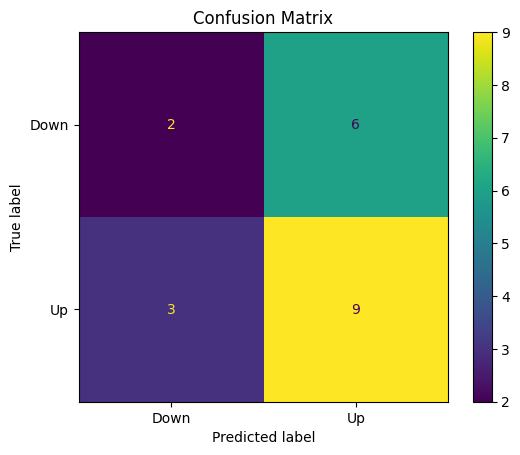

In [13]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#Load data
sent = pd.read_excel("stock_news_tone.xlsx")
sp = pd.read_csv("sp500_cleaned.csv")
sent["date"] = pd.to_datetime(sent["date"])
sp["date"] = pd.to_datetime(sp["date"])

#Merge datasets
df = (
    pd.merge(sent, sp, on="date", how="inner")
      .rename(columns={"label_y": "label"})
      .query("label != 0")
      .dropna()
      .sort_values("date")
      .reset_index(drop=True)
)

#Shift labels
df["label_next"] = df["label"].shift(-1).astype("Int64")
df = df.dropna(subset=["label_next"]).reset_index(drop=True)

# Feature list
base_features = [
    'sent_pos','sent_neg','sent_neu','sent_compound',
    'emo_fear','emo_anger','emo_anticip','emo_trust',
    'emo_surprise','emo_positive','emo_negative',
    'emo_sadness','emo_disgust','emo_joy'
]

#Add lag features
for feat in base_features:
    df[f"{feat}_lag1"] = df[feat].shift(1)
    df[f"{feat}_ma3"] = df[feat].rolling(3).mean()

#Drop rows
df = df.dropna().reset_index(drop=True)

#Define final features
features = [col for col in df.columns if col.startswith('sent_') or col.startswith('emo_')]

#Train Random Forest model
scaler_all = StandardScaler().fit(df[features])
X_scaled = scaler_all.transform(df[features])
model_all = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
model_all.fit(X_scaled, df["label_next"])

#Back-test with rolling training
history = []
for i in range(1, len(df)):
    train = df.iloc[:i]
    test_row = df.iloc[i]
    
    if train["label_next"].nunique() < 2:
        pred = train["label_next"].iloc[-1]
        conf = 1.0
    else:
        scaler_bt = StandardScaler().fit(train[features])
        model_bt = RandomForestClassifier(n_estimators=200, random_state=42)
        model_bt.fit(scaler_bt.transform(train[features]), train["label_next"])
        X_test = scaler_bt.transform([test_row[features]])
        pred = model_bt.predict(X_test)[0]
        conf = model_bt.predict_proba(X_test).max()
    
    history.append({
        "date": test_row["date"],
        "sent_compound": test_row["sent_compound"],
        "actual_label": "Up" if test_row["label_next"] == 1 else "Down",
        "predicted_label": "Up" if pred == 1 else "Down",
        "prediction_confidence": conf
    })

#Evaluate
history_df = pd.DataFrame(history)
y_true = history_df["actual_label"].map({'Up': 1, 'Down': 0})
y_pred = history_df["predicted_label"].map({'Up': 1, 'Down': 0})
print("\n Classification Performance:")
print(f"Accuracy : {accuracy_score(y_true, y_pred):.2%}")
print(f"F1 Score : {f1_score(y_true, y_pred):.2f}")
print(f"Precision: {precision_score(y_true, y_pred):.2f}")
print(f"Recall   : {recall_score(y_true, y_pred):.2f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()


### Topic Analysis for Up and Down Stock


[nltk_data] Downloading package stopwords to /home/runner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


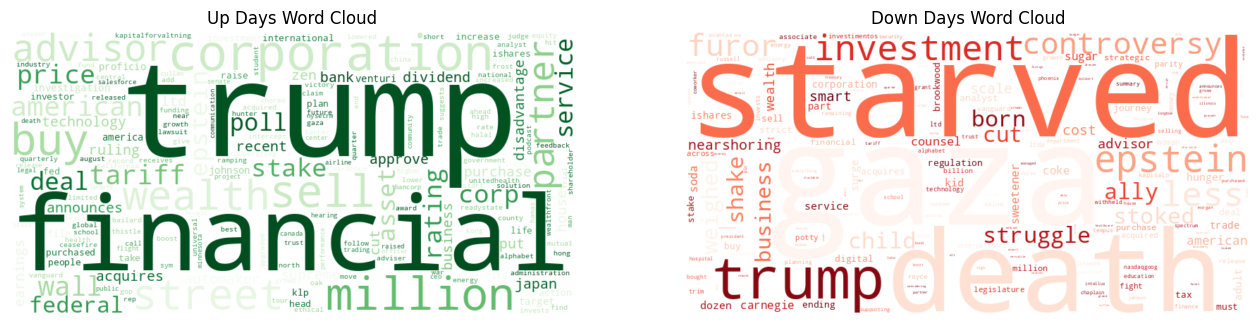

In [14]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
import string
import os

#Download stopwords if not already available
nltk.download('stopwords')
from nltk.corpus import stopwords

#Load data
topic_df = pd.read_csv("topic_modeling.csv", parse_dates=["date"])
prediction_df = pd.read_csv("prediction_results.csv", parse_dates=["date"])

#Merge datasets
merged_df = pd.merge(topic_df, prediction_df, on="date", how="inner")
merged_df = merged_df.dropna(subset=['actual_label', 'Headline'])
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Filter to last 7 days only
recent_cutoff = merged_df['date'].max() - pd.Timedelta(days=7)
recent_df = merged_df[merged_df['date'] >= recent_cutoff].copy()

#Token cleaning function
def clean_token(w):
    return (
        w.strip(string.punctuation)
         .lower()
         .replace("’", "")
         .replace("‘", "")
         .replace("“", "")
         .replace("”", "")
    )

#Tokenize and clean
recent_df["tokens"] = recent_df["Headline"].str.lower().str.split().apply(
    lambda tokens: [clean_token(t) for t in tokens if len(clean_token(t)) > 2]
)

#Flatten tokens by label
up_words = recent_df[recent_df["actual_label"] == "Up"]["tokens"].explode()
down_words = recent_df[recent_df["actual_label"] == "Down"]["tokens"].explode()

#Count words
up_counts = Counter(up_words)
down_counts = Counter(down_words)

# Stopwords
stop_words = set(stopwords.words("english"))
custom_stopwords = stop_words.union({
    "stock", "market", "shares", "company", "us", "report", "reports", "says",
    "new", "one", "year", "would", "could", "today", "also"
})

# Filter common and clean
filtered_up = {w: c for w, c in up_counts.items() if w not in custom_stopwords}
filtered_down = {w: c for w, c in down_counts.items() if w not in custom_stopwords}

# WordClouds
up_wc = WordCloud(width=800, height=400, background_color="white", colormap="Greens").generate_from_frequencies(filtered_up)
down_wc = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate_from_frequencies(filtered_down)

#save plots
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(up_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Up Days Word Cloud")

plt.subplot(1, 2, 2)
plt.imshow(down_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Down Days Word Cloud")


#Export for Streamlit
up_df = pd.DataFrame(filtered_up.items(), columns=["word", "count"])
up_df["label"] = "Up"
down_df = pd.DataFrame(filtered_down.items(), columns=["word", "count"])
down_df["label"] = "Down"

word_freq_df = pd.concat([up_df, down_df], ignore_index=True)
word_freq_df.to_csv("topic_up_down.csv", index=False)
